# **Exploratory component**

## **Introduction**

We are now considering a more in-depth analysis about the data. With all the accessibility-related information that we have, we want to cluster the different neighbourhoods by accessibility and then try to identify the type of neighbourhood that it corresponds to. So the question is: __How should we cluster our data in order to identify the different localities in the city?__

In addition, we will also try to get some more data that will give us more information on the neighborhoods. This data will be collected via either the _Yelp_ or the _Google Maps_ API. By doing so we will be able to get locations of stores, businesses, restaurants,... and their corresponding reviews given by customers. This will help us compute new features to add to our original dataset and will hopefully help us increasing our classifier accuracy and give us more insights to answer the above question.

Note: this notebook is run on googlecolab so some of the code reflect this feature by calling an API to collect data. 

## **Preparation**


This part is almost identical to the preparation part in the previous notebooks. Therefore, there is no further explanation of the steps made provided. Some graphs are plotted to make sure the codes and data are correct. Please check that you have the python libraries and the change the file locations if needed.

### **Package import**

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pip install geopandas pyshp;

     |████████████████████████████████| 921kB 8.2MB/s 
     |████████████████████████████████| 225kB 18.6MB/s 
     |████████████████████████████████| 10.1MB 34.3MB/s 
     |████████████████████████████████| 11.8MB 198kB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32607 sha256=1750b1de6d622f819cffc846c13bb4e2f7fd02f265b0a2a69c70675fb1690222
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
# Note that you need to install all those python packages to run the notebook
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import geopandas as gpd
import numpy as np
import shapefile
from pyproj import Proj, transform


### **Data collection and cleansing**

In [0]:
# add the name of the folder with the shape files (the folder should be identical as the one on DTU inside)
folder_shape_files = 'drive/My Drive/shape-files-ds-for-mobility'

# in the later we might have used use files[4] which is ZonasEOD2012.shp
files = os.listdir(folder_shape_files)

# change here if you want to load locally 
dataset_location = "https://gist.githubusercontent.com/JulesBelveze/776c1b404d59cfdf7896da9074246a18/raw/78bfa8bb98bbb0ce3c7eb074527e78eae9cf7c6e/Households%2520Data.csv"

In [0]:
df = pd.read_csv(dataset_location, sep=';', error_bad_lines=False, decimal=',');

b'Skipping line 17: expected 30 fields, saw 31\nSkipping line 47: expected 30 fields, saw 58\n'


In [0]:
columns = df.columns.tolist()
print("Columns: {}".format(columns))
print("DataFrame shape: {}".format(df.shape))

Columns: ['Hogar', 'EXCLUIR', 'paraValidacion', 'Sector', 'DirCoordX', 'DirCoordY', 'MontoArr', 'IngresoHogar', 'Factor', 'AnosEstudio', 'CLASE', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv', 'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM', 'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub', 'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub', 'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto', 'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto', 'Acc_Servicios_auto', 'CLUSTER7', 'CLUSTER2']
DataFrame shape: (18292, 30)


In [0]:
# removing row to exclude
df = df[df['EXCLUIR'] == 0]

# removing not allowed columns
new_columns = columns[columns.index('CLASE'):]
df_filtered = df[new_columns]

df_filtered.head()

,CLASE,Sup_Prom_Constr_Hab_EOD,Calid_EOD_norm_inv,DensConstr_EOD,Dist_est_Metro_MC_KM,Dist_salida_Autop_MC_KM,Tiempo_Com_Stgo,Ingreso_Promedio_Zona_MM,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto,CLUSTER7,CLUSTER2
0,1,53.8,0.98,0.059,23.051711,4.345179,69,0.519765,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
1,1,59.6,0.98,0.033,21.080177,1.381521,84,0.678317,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
2,1,59.5,0.98,0.004,34.147894,11.993389,83,0.408158,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
3,2,59.5,0.98,0.004,34.147817,11.993268,83,0.408158,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
4,2,43.6,0.98,0.086,19.908792,1.363177,94,0.498140,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1


### **Zone shapefile manipulation**

Number of the geometries: 866


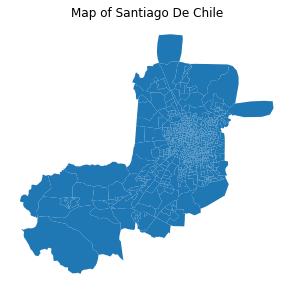

In [0]:
# load of ZonasEOD2012.shp
map = gpd.read_file(os.path.join(folder_shape_files, 'ZonasEOD2012.shp')) #read the file from the drive
print("Number of the geometries:", len(map))
ax = map.plot(figsize=(5,5)); #plot the map
ax.set_title('Map of Santiago De Chile');
ax.axis('off');

In [0]:
# reading shapefile and collecting info
sf = shapefile.Reader(os.path.join(folder_shape_files, 'ZonasEOD2012.shp')) 

shapes = sf.shapes() #geometry of the zones
records = sf.records() #attributes of the zones
coordX = np.array(df['DirCoordX']) #change to numpy array just to be sure
coordY = np.array(df['DirCoordY'])

In [0]:
zones = []
for i in range(len(df)): #all entries
    assigned = False
    for j in range(len(shapes)): #go through all zones
        if coordX[i]>=shapes[j].bbox[0] and coordX[i]<=shapes[j].bbox[2] and coordY[i]>=shapes[j].bbox[1] and coordY[i]<=shapes[j].bbox[3]: #if entry belongs to the polygon
            zones.append(records[j][1]) #assign first zone ID 'Com'
            assigned = True
            break 
    if not assigned:
      print("Observation {} not in any zone".format(i))

Observation 9329 not in any zone
Observation 9362 not in any zone


In [0]:
# removing both previous points 
df_formap = df.copy()
df_formap = df_formap.drop([9329, 9362], axis=0)

assert len(df_formap) == len(zones)

df_formap['zone'] = zones

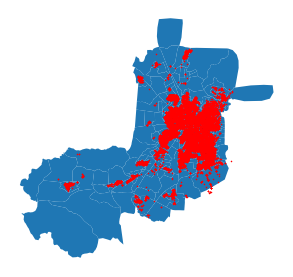

In [0]:
ax = map.plot(figsize=(5,5));
plt.plot(df_formap['DirCoordX'],df_formap['DirCoordY'], '*', color='r', markersize=1);
plt.axis('off');

Let's also see how many entries there are per zone.

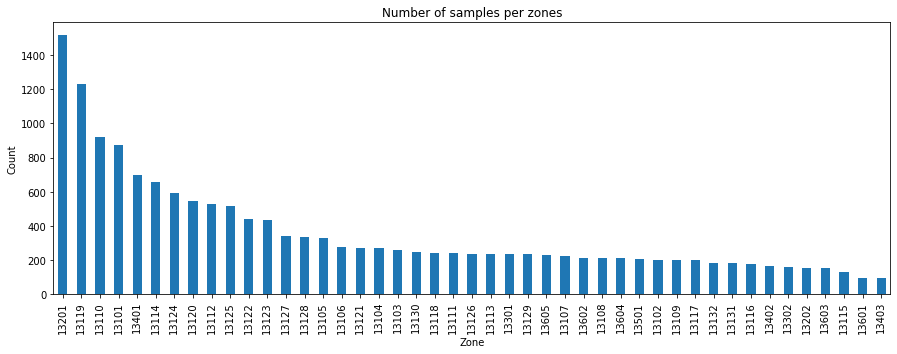

In [0]:
df_formap['zone'].value_counts().plot(kind='bar', figsize=(15,5));
plt.xlabel("Zone");
plt.ylabel("Count");
plt.title('Number of samples per zones');

### **Changing the coordinates to real world coordinates**

In [0]:
map.crs #which type of projection is the map using

{'init': 'epsg:32719'}

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


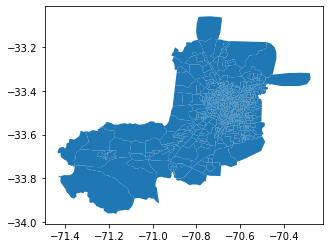

In [0]:
map_projection = map.copy(); #just to be sure
map_projection = map_projection.to_crs(epsg=4326); #different type of coding (just the coordinates change)
map_projection.plot();

In [0]:
df_map = df_formap.copy() #just to be sure
inProj, outProj = Proj(init='epsg:32719'), Proj(init='epsg:4326') #changing the projecting format 
df_map['DirCoordX'], df_map['DirCoordY'] = transform(inProj, outProj, df_map['DirCoordX'].tolist(), df_map['DirCoordY'].tolist()) #applying the formating change

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


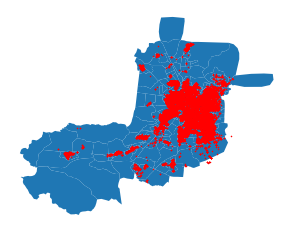

In [0]:
ax = map_projection.plot(figsize=(5,5));
plt.plot(df_map['DirCoordX'],df_map['DirCoordY'], '*', color='r', markersize=1);
plt.axis('off');

## **Plotting different attributes for the zones**

Now lets analyze some parameters of our households dataset on the 'Acc_'. We are especially gonna focus on plotting the different standard deviation to justify that we used a mean over all the samples of a zone in the later. 

In [0]:
accs = ['Acc_Comercio_tpte_pub', 'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto']

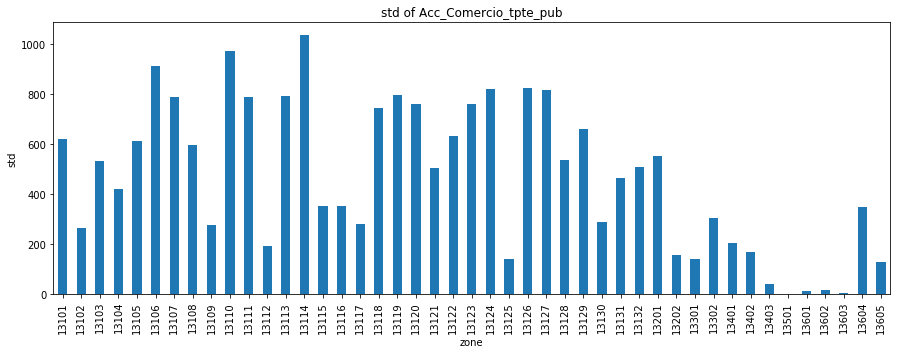

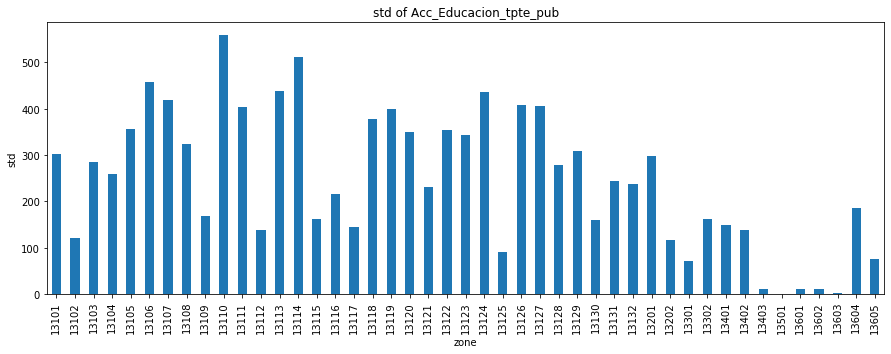

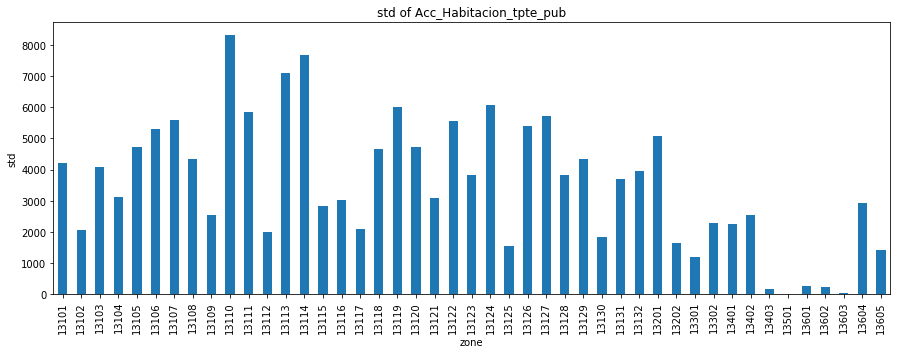

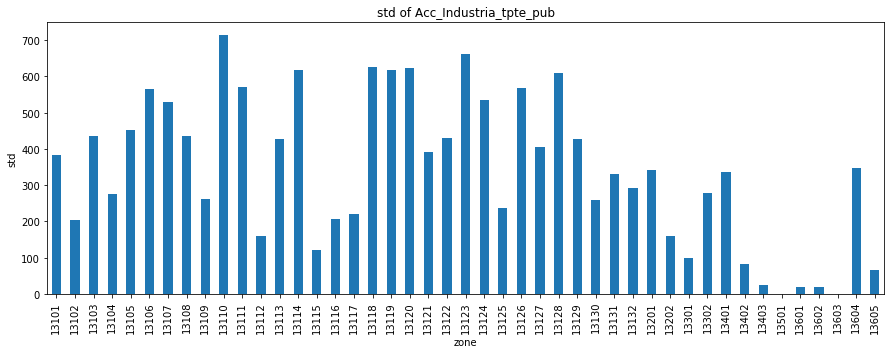

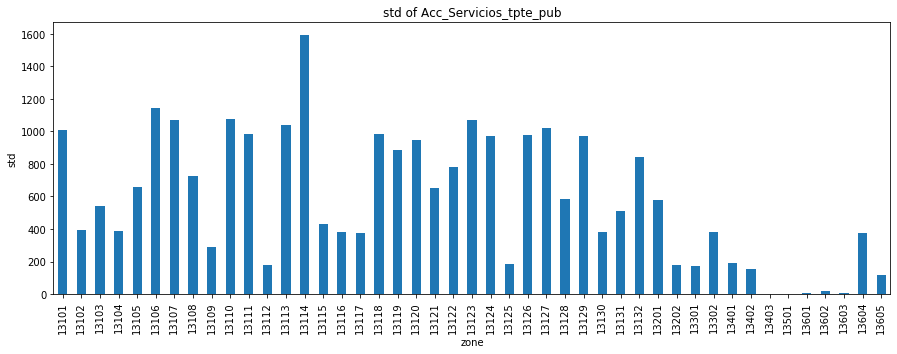

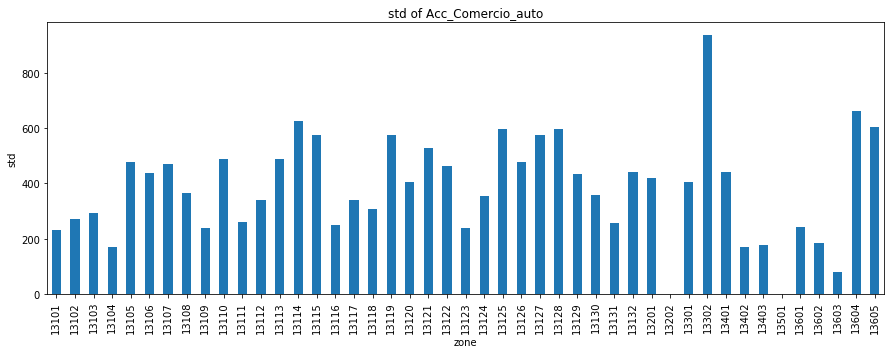

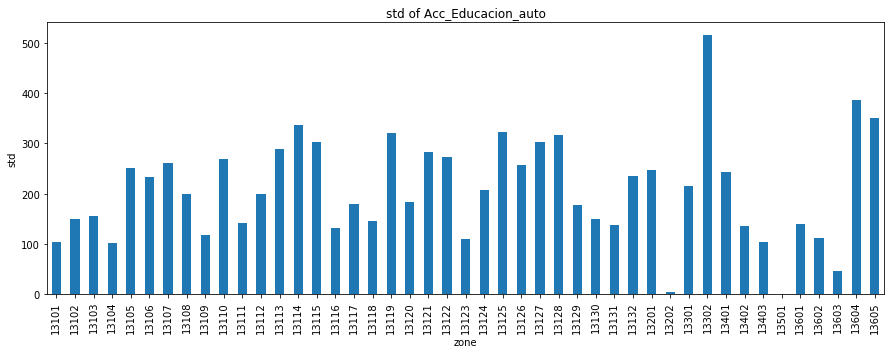

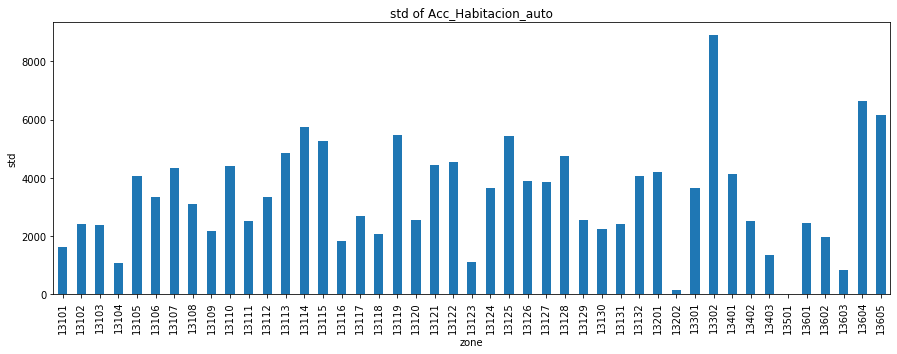

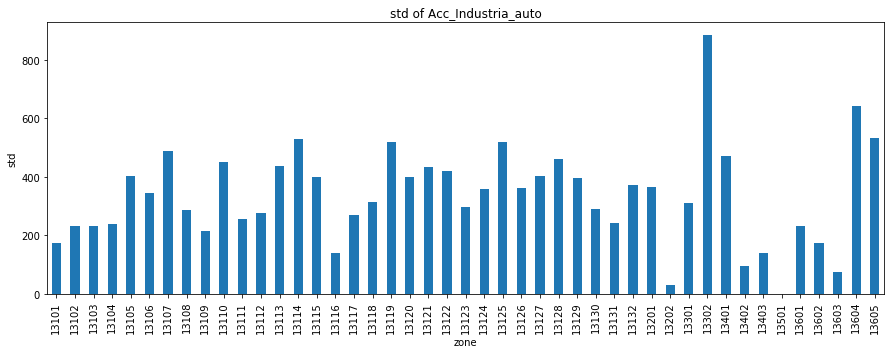

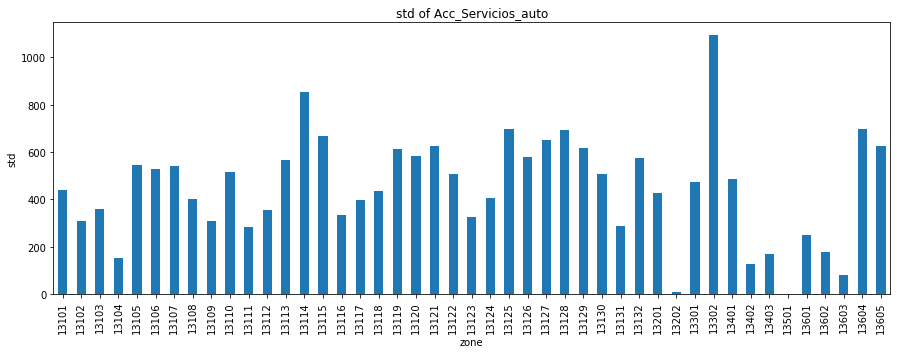

In [0]:
for acc in accs:
  df_formap.groupby(by='zone')[acc].std().plot(kind='bar', figsize=(15,5));
  plt.xlabel("zone");
  plt.ylabel("std");
  plt.title('std of {}'.format(acc));
  plt.show()

We can see that the standard deviations are quite high for some of the zones. That is why we will then compare a clustering by zones and by samples.

## **Clustering the different zones depending on the accessibility**

From now on, we want to cluster our data to get some insights about accessibilities and the different zones of the city. First, we are gonna group by zones and averaging to cluster by zones.

In [0]:
# definition of the min pop in a zone
min_pop = 0

# get a column with the count of pop in zones
zone_counts = df_formap['zone'].value_counts().to_dict()

df_formap['count_pop_zone'] = df_formap['zone'].apply(lambda x: zone_counts[x])
df_zones = df_formap[df_formap['count_pop_zone'] > min_pop]

print('we selected {} zones to cluster out of {}. We only selected the zones with more than {} datapoints.'.format(
                      df_zones.groupby(by='zone').count().shape[0],
                      len(zone_counts),
                      min_pop,
      ))

we selected 45 zones to cluster out of 45. We only selected the zones with more than 0 datapoints.


Since we only have 45 zones, we decided to keep them all even if there is a ratio of one tenth in the number of data points per zone. (you can see that in the plot titled: 'Number of samples per zones' above)

In [0]:
# selection of variables that are going to be useful later
to_keep = ['Acc_Comercio_tpte_pub', 'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'zone', 'count_pop_zone']
df_zones = df_zones[to_keep]

In [0]:
# let's try to group by zones in order to get a clustering of the zones
df_zones_mean = df_zones.groupby(by='zone').mean()
print(df_zones_mean.shape)
df_zones_mean.head()


(45, 11)


,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto,count_pop_zone
zone,,,,,,,,,,,
13101,5158.309126,2652.480676,37111.889525,3726.862790,6171.199830,8158.411707,4464.806140,72638.981054,6703.198110,9256.719920,873
13102,1973.677194,1099.721602,19099.172010,2196.264492,1977.502903,6288.989303,3663.947811,63488.059254,6078.710846,6438.313682,201
13103,1921.998466,1081.237749,19354.963089,1885.308059,1966.665710,6312.981004,3519.142973,60360.970347,5671.972819,7119.098687,259
13104,2179.575178,1165.018638,18233.993870,2427.151757,2622.907203,6731.959588,3705.710375,63031.437790,5909.728427,7840.563783,267
13105,1675.201461,1180.615164,18306.466816,1455.604455,1400.404922,5744.902818,3461.887545,59046.379879,5191.131485,5722.989061,330


Here, we are ready to cluster.

In [0]:
# Clustering using KMeans
nb_clusters = 6
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=nb_clusters, random_state=0)
kmeans.fit(df_zones_mean.drop(columns=['count_pop_zone']))
df_zones_mean['clusters'] = kmeans.predict(df_zones_mean.drop(columns=['count_pop_zone']))

In [0]:
# group cluster will contain the mean of each variable per cluster
group_cluster = df_zones_mean.drop(columns=['count_pop_zone']).groupby(by='clusters').mean()
group_cluster

,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto
clusters,,,,,,,,,,
0,1687.090633,1031.502472,17275.745119,1599.294697,1736.812142,5643.605027,3292.727655,57040.857022,5133.068352,5988.197999
1,126.934515,72.651724,1289.609820,129.403339,137.589288,1463.475158,855.545849,15106.178239,1430.801401,1485.657900
2,3611.262014,2033.427003,31077.829365,2689.648510,4010.582550,7003.957696,4000.796435,67692.673585,5923.704458,7568.869284
3,865.069201,527.614111,9677.601493,596.206085,879.944335,4373.686399,2541.112898,44264.903424,3794.149417,4590.143694
4,2270.298707,1265.792053,21145.406827,1991.697385,2454.327966,6784.680509,3828.322811,65497.974718,5784.372343,7455.506517
5,498.306962,290.237960,4718.590056,455.674949,551.092648,3006.941767,1717.485009,29875.615989,2830.462938,3293.442515


In [0]:
# plotting the number of zones in each clusters
print("Clusters repartition:");
df_zones_mean['clusters'].value_counts(sort=False)

Clusters repartition:


0     9
1     4
2    15
3     4
4     9
5     4
Name: clusters, dtype: int64

We tried different number of clusters until having at least 4 zones in each cluster. 

In [0]:
# function for plotting
def next_step(previous, limx, limy):
  """given previous tuple, return the next tuple on a defined grid"""
  return_x, return_y = previous
  if previous[1]+1 < limy:
    return_y += 1
    return return_x, return_y
  else:
    return return_x+1, 0

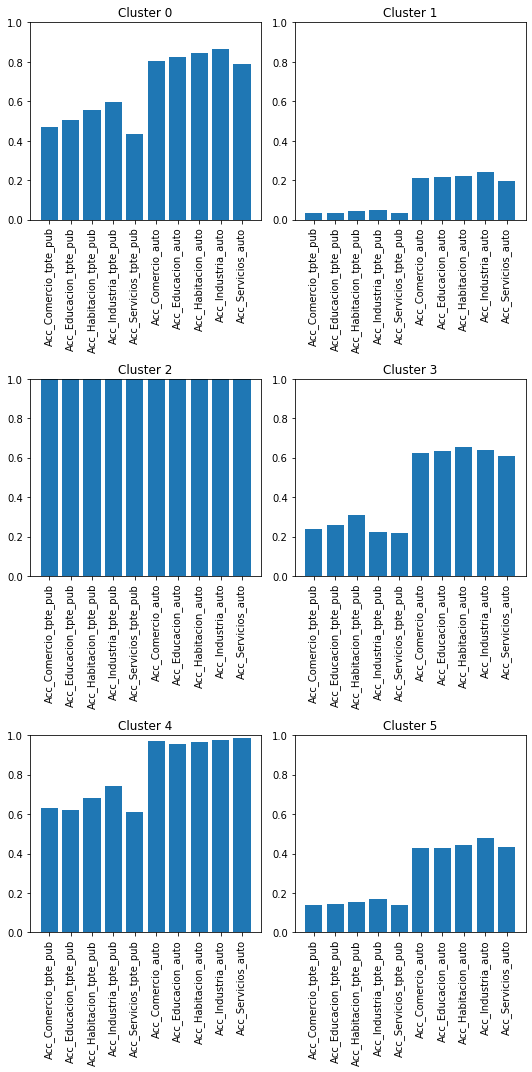

In [0]:
# study of the different clusters
# we will divide by the max value over all clusters for a better visualization
columns = group_cluster.columns
for col in columns:
  max_col = max(group_cluster[col])
  group_cluster[col] = group_cluster[col]/max_col


dict_group_cluster = group_cluster.to_dict()
np_group_cluster = group_cluster.to_numpy()


fig, ax_tot = plt.subplots(3, 2, figsize=(7.5, 15))
grid_loc = (0, 0)
for i in range(nb_clusters):
  ax = ax_tot[grid_loc]
  grid_loc = next_step(grid_loc, 3, 2)
  data = np_group_cluster[i]
  ax.bar(columns, data)
  plt.setp(ax.get_xticklabels(), rotation=90)
  ax.set_title('Cluster {}'.format(i))
  ax.set_ylim(bottom=0, top=1)
plt.tight_layout()

What we see above is that the model is distinguishing the different zones by a global level of accessibility. That is to say, it is not only one type of accessibility that changes between clusters (eg only education) but the overall level. We had the hint of the phenomenon on the first part of the study when we saw that those variables are correlated. We can also see great differences between the zones. For instance, we could imagine that in a cluster where the accessibility is low, people are using the car for everything.

Let see how it actually looks on a map.

In [0]:
# plot of the clustering on a map:
dict_clus = df_zones_mean['clusters'].to_dict()
new = map.copy()
new['cluster'] = new['Com'].apply(lambda x: dict_clus[x] if x in dict_clus else None)
new = new.dropna()


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


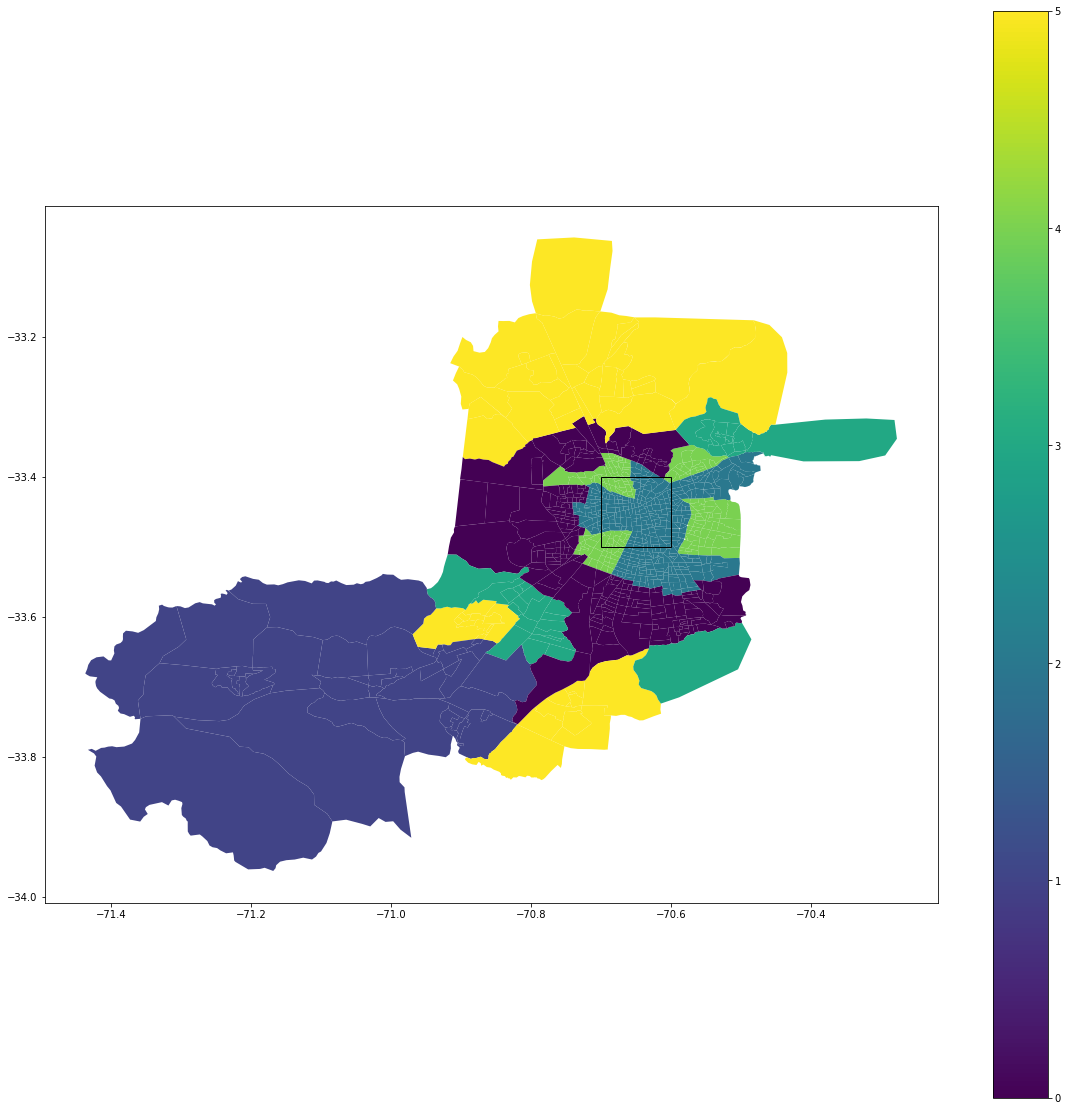

In [0]:
new = new.to_crs(epsg=4326) #different type of coding (just the coordinates change)


fig, ax = plt.subplots(1, 1, figsize=(20, 20))
new.plot(column='cluster', ax=ax, legend=True)

# just to see where is located the test dataset from the classification problem
from matplotlib import patches
ax.add_patch(
    patches.Rectangle((-70.7,-33.5), .1, .1, angle=0.0, fill=False))

The insigths drawn from the plot seems to follow perfectly the geography of the city. The farther form the city center, the lower the accessibility. This relatively short analysis confirm that the way of living, the relevance of the data and the pattern we could find depends on the location. That is a factor that could explain the lack of accuracy of the classification. It is difficult to predict the test set (the square on the plot) using a train set with so different characteristics. 

## **Clustering on the same variable at the house level**

We are now gonna cluster on all the samples, without doing a mean on the zones. Since we have quite high standard deviations, this might give us more insigths on the different parts of the city.

In [0]:
# formatting for the clustering
to_keep = ['Acc_Comercio_tpte_pub', 'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
           'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
           'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
           'Acc_Servicios_auto', 'zone', 'DirCoordX', 'DirCoordY']
to_drop_clustering = ['zone', 'DirCoordX', 'DirCoordY']

df_house_acc = df_map[to_keep]
df_house_acc.head()

,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto,zone,DirCoordX,DirCoordY
0,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,13402,-70.779034,-33.729444
1,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,13402,-70.744339,-33.737278
2,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,13402,-70.859655,-33.805994
3,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,13402,-70.859653,-33.805995
4,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,13402,-70.743269,-33.722055


In [0]:
# Clustering using KMeans
nb_clusters = 6
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=nb_clusters, random_state=0)
kmeans.fit(df_house_acc.drop(columns=to_drop_clustering))
df_house_acc['clusters'] = kmeans.predict(df_house_acc.drop(columns=to_drop_clustering))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
# plotting the number of zones in each clusters
df_house_acc['clusters'].value_counts(sort=False)

0    3326
1    2859
2     778
3    4065
4    4304
5     740
Name: clusters, dtype: int64

In [0]:
# group cluster will contain the mean of each variable per cluster
group_cluster_house = df_house_acc.drop(columns=to_drop_clustering).groupby(by='clusters').mean()
group_cluster_house

,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto
clusters,,,,,,,,,,
0,4401.526607,2391.338984,35925.521811,3054.092217,5146.965732,7467.286076,4200.266314,70517.688596,6121.549621,8247.959245
1,1099.243975,715.478331,12571.325295,975.258926,1077.986214,4823.700458,2877.953498,50126.901116,4381.544813,4933.121098
2,476.160723,278.727365,4824.699407,465.731522,520.179145,3051.753548,1749.200424,30552.179010,2890.950398,3289.730527
3,1718.960604,1050.385909,18083.998973,1474.635493,1738.237059,5788.620546,3389.669316,58739.659840,5084.936718,6096.009909
4,2808.545459,1585.104821,25659.096288,2242.205507,3019.976544,6692.407351,3829.069040,65612.871673,5763.698978,7209.690446
5,124.340414,71.456965,1230.520362,121.939048,136.439305,1471.978527,855.101757,15058.668581,1439.787919,1529.746932


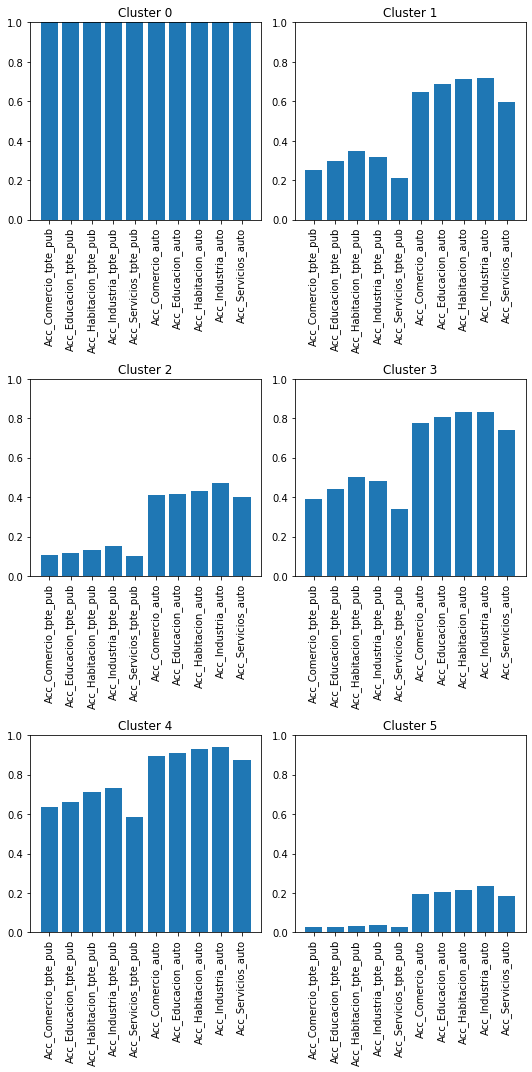

In [0]:
# study of the different clusters
# we will divide by the max value over all clusters for a better visualization
columns = group_cluster_house.columns
for col in columns:
  max_col = max(group_cluster_house[col])
  group_cluster_house[col] = group_cluster_house[col]/max_col


dict_group_cluster = group_cluster_house.to_dict()
np_group_cluster = group_cluster_house.to_numpy()


fig, ax_tot = plt.subplots(3, 2, figsize=(7.5, 15))
grid_loc = (0,0)
for i in range(nb_clusters):
  ax = ax_tot[grid_loc]
  grid_loc = next_step(grid_loc, 3, 2)
  data = np_group_cluster[i]
  ax.bar(columns, data)
  plt.setp(ax.get_xticklabels(), rotation=90)
  ax.set_title('Cluster {}'.format(i))
  ax.set_ylim(bottom=0, top=1)
plt.tight_layout()

We can see pretty much the same patterns than before with the zones. That is to say that, the accessibilities are correlated and the clusters define a global level of accessibility. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


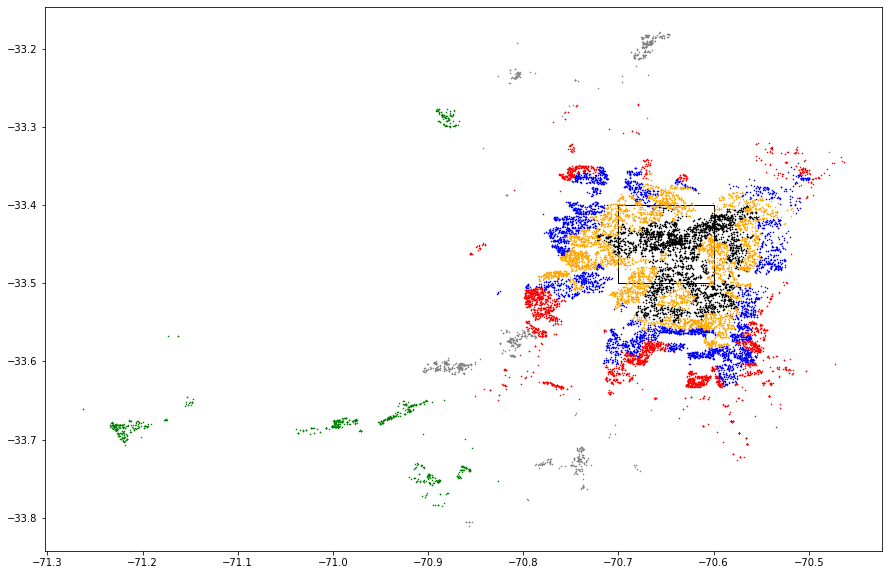

In [0]:
fig =plt.figure(figsize=(15,10))
plt.plot(df_house_acc.loc[df_house_acc['clusters']==0]['DirCoordX'], df_house_acc.loc[df_house_acc['clusters']==0]['DirCoordY'], '*', color='black', markersize=1);
plt.plot(df_house_acc.loc[df_house_acc['clusters']==1]['DirCoordX'], df_house_acc.loc[df_house_acc['clusters']==1]['DirCoordY'], '*', color='r', markersize=1);
plt.plot(df_house_acc.loc[df_house_acc['clusters']==2]['DirCoordX'], df_house_acc.loc[df_house_acc['clusters']==2]['DirCoordY'], '*', color='gray', markersize=1);
plt.plot(df_house_acc.loc[df_house_acc['clusters']==3]['DirCoordX'], df_house_acc.loc[df_house_acc['clusters']==3]['DirCoordY'], '*', color='blue', markersize=1);
plt.plot(df_house_acc.loc[df_house_acc['clusters']==4]['DirCoordX'], df_house_acc.loc[df_house_acc['clusters']==4]['DirCoordY'], '*', color='orange', markersize=1);
plt.plot(df_house_acc.loc[df_house_acc['clusters']==5]['DirCoordX'], df_house_acc.loc[df_house_acc['clusters']==5]['DirCoordY'], '*', color='green', markersize=1);

from matplotlib import patches
ax = fig.add_subplot(1, 1, 1)
ax.add_patch(
    patches.Rectangle((-70.7,-33.5), .1, .1, angle=0.0, fill=False))

We can see a more precise clustering but the idea seems to be still the same. That is to say, the center concentrates the activities and elsewhere it is difficult to access them. It also corresponds to different density of population. However, we can see more differences between neighbourhoods if we focus on the 'black' and 'orange' clusters. The 'black' cluster is the hyper center and corresponds to the maximum accessibility. The 'orange' zones might correspond to residential areas still close to the center. 

## **Conclusion**

To conclude this explanatory part, the city is organised like concentric circles. The city center concentrates the activities and the distances are really short. The farther from the center, the greater the distances are to access anything. It seemed like taking zones or all the samples did not really changed this observation. Also, we can see that all the accessibility variables are really correlated since they depend mostly on the location. Nevertheless, a more in-depth study could investigate the differences between the 'black' and the 'orange' cluster to identify different type of neighbourhoods around the city center. 

When considering the classification challenge and the way the training and test sets are divided, we can wonder if training on the outskirt would give us good prediction on the center. Indeed, it seems that life styles are quite different depending on where people live. Hence, we might have patterns that are not in the training set but in the test set. 

# **Conclusion to the Challenge**
The first part was dedicated to a preliminary analysis. We could apprehend the dataset and the different variables. It was insightful especially when it came to select our variables. It is also at this moment that we got a hint of the uneven geographic location of the train and test set. 

In the second part, we used the learnings from to first part to build a classifier. Our classifier ended up performing at 57% accuracy (compared to approx 50% for any model at the beginning). To achieve that we used a PCA on some variables that were correlated. We also added some data from Yelp API to increase the amount of information.

The last part constitutes a small study of the accessibility in the city. We tried to cluster by zones and then samples depending on the values of the variables concerning accessibility. The result is that we can clearly see how the activities are all concentrated in the city center. The farther from the city center, the scarcer it becomes. 

This challenge was not a straight forward 100% accuracy project. However, it was interesting to try to make the best of it. Although, in real life, this type of project would benefit so much from domain knowledge. It would be really useful to work with someone from the city that can give some insights and common representations of Santiago de Chile.